# Exploring the Advantage of Sobol Sequences

c:\Users\alexf\miniconda3\envs\myenv\Lib\site-packages\scipy\stats\_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


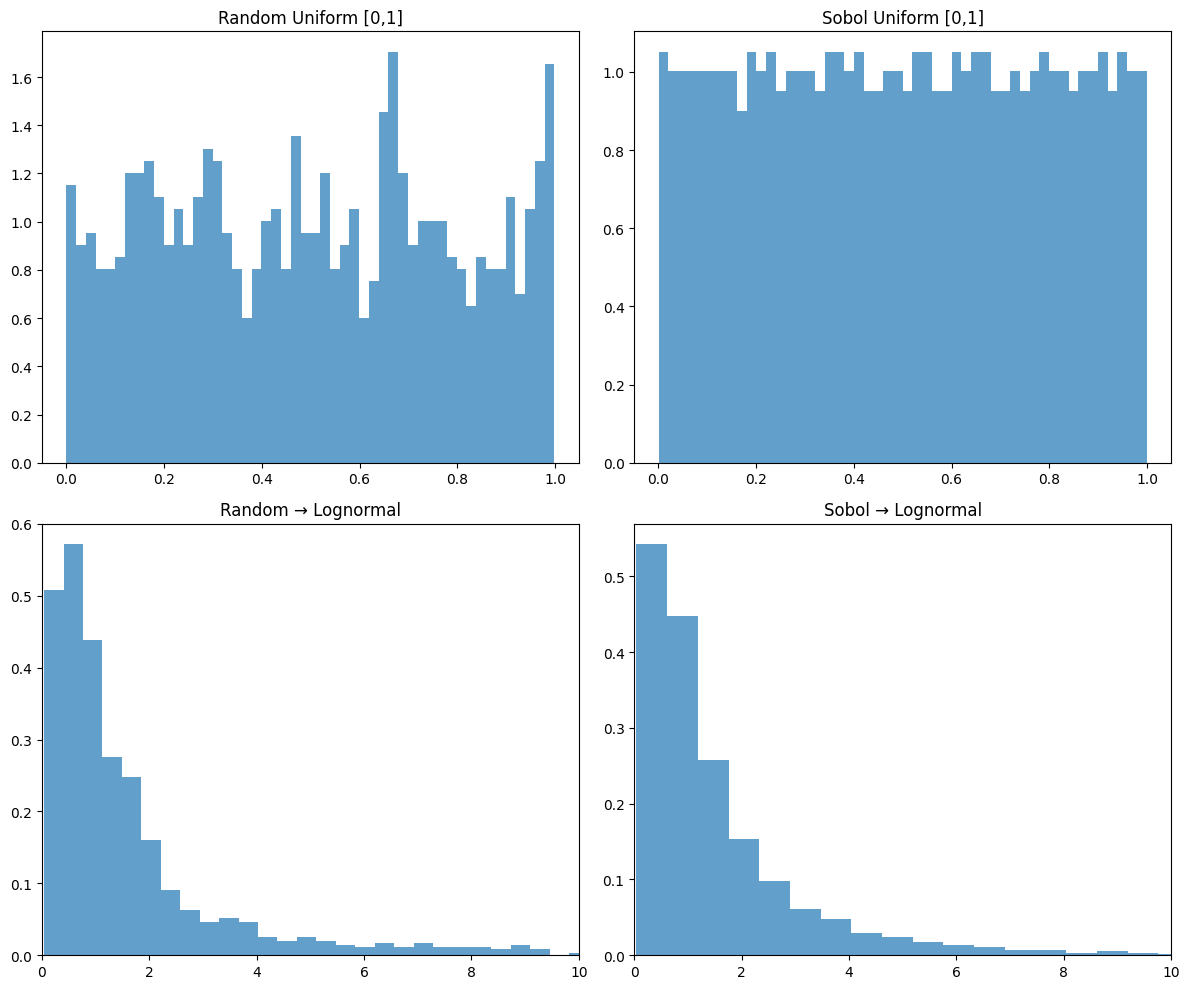

In [1]:
import numpy as np
from scipy.stats import qmc, norm, lognorm
import matplotlib.pyplot as plt

def visualize_transform_preservation(n_points=1000):
    """
    Show how Sobol's evenness is preserved through inverse CDF transform
    """
    # Generate random and Sobol uniforms
    random_uniform = np.random.uniform(0, 1, n_points)
    sobol = qmc.Sobol(d=1, scramble=True)
    sobol_uniform = sobol.random(n_points).flatten()
    
    # Transform to Lognormal(0, 1)
    random_lognormal = lognorm.ppf(random_uniform, s=1)
    sobol_lognormal = lognorm.ppf(sobol_uniform, s=1)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: Uniform samples
    axes[0,0].hist(random_uniform, bins=50, alpha=0.7, density=True, label='Random')
    axes[0,0].set_title('Random Uniform [0,1]')
    
    axes[0,1].hist(sobol_uniform, bins=50, alpha=0.7, density=True, label='Sobol')
    axes[0,1].set_title('Sobol Uniform [0,1]')
    
    # Plot 2: Transformed samples
    axes[1,0].hist(random_lognormal, bins=50, alpha=0.7, density=True)
    axes[1,0].set_title('Random → Lognormal')
    axes[1,0].set_xlim(0, 10)
    
    axes[1,1].hist(sobol_lognormal, bins=50, alpha=0.7, density=True)
    axes[1,1].set_title('Sobol → Lognormal')
    axes[1,1].set_xlim(0, 10)
    
    plt.tight_layout()
    return random_lognormal, sobol_lognormal

# Run visualization
random_vals, sobol_vals = visualize_transform_preservation(n_points=1000)

In [2]:
def demonstrate_estimation_quality(n_simulations=50, n_points=500):
    """
    Compare how well random vs Sobol estimates converge to true values
    """
    # True values for Lognormal(0, 1)
    true_mean = np.exp(0.5)  # e^(μ + σ²/2)
    true_99_percentile = lognorm.ppf(0.99, s=1)  # For VaR
    
    random_estimates_mean = []
    sobol_estimates_mean = []
    random_estimates_var99 = []
    sobol_estimates_var99 = []
    
    for sim in range(n_simulations):
        # Random approach
        random_uniform = np.random.uniform(0, 1, n_points)
        random_lognormal = lognorm.ppf(random_uniform, s=1)
        random_estimates_mean.append(np.mean(random_lognormal))
        random_estimates_var99.append(np.percentile(random_lognormal, 99))
        
        # Sobol approach
        sobol = qmc.Sobol(d=1, scramble=True)
        sobol_uniform = sobol.random(n_points).flatten()
        sobol_lognormal = lognorm.ppf(sobol_uniform, s=1)
        sobol_estimates_mean.append(np.mean(sobol_lognormal))
        sobol_estimates_var99.append(np.percentile(sobol_lognormal, 99))
    
    # Calculate standard deviations
    random_std_mean = np.std(random_estimates_mean)
    sobol_std_mean = np.std(sobol_estimates_mean)
    random_std_var = np.std(random_estimates_var99)
    sobol_std_var = np.std(sobol_estimates_var99)
    
    print(f"Estimating Mean (true value: {true_mean:.4f}):")
    print(f"  Random MC: std = {random_std_mean:.6f}")
    print(f"  Sobol QMC: std = {sobol_std_mean:.6f}")
    print(f"  Improvement factor: {random_std_mean/sobol_std_mean:.2f}x\n")
    
    print(f"Estimating 99% VaR (true value: {true_99_percentile:.4f}):")
    print(f"  Random MC: std = {random_std_var:.6f}")
    print(f"  Sobol QMC: std = {sobol_std_var:.6f}")
    print(f"  Improvement factor: {random_std_var/sobol_std_var:.2f}x")

demonstrate_estimation_quality()

Estimating Mean (true value: 1.6487):
  Random MC: std = 0.079204
  Sobol QMC: std = 0.024554
  Improvement factor: 3.23x

Estimating 99% VaR (true value: 10.2405):
  Random MC: std = 1.292417
  Sobol QMC: std = 0.305828
  Improvement factor: 4.23x


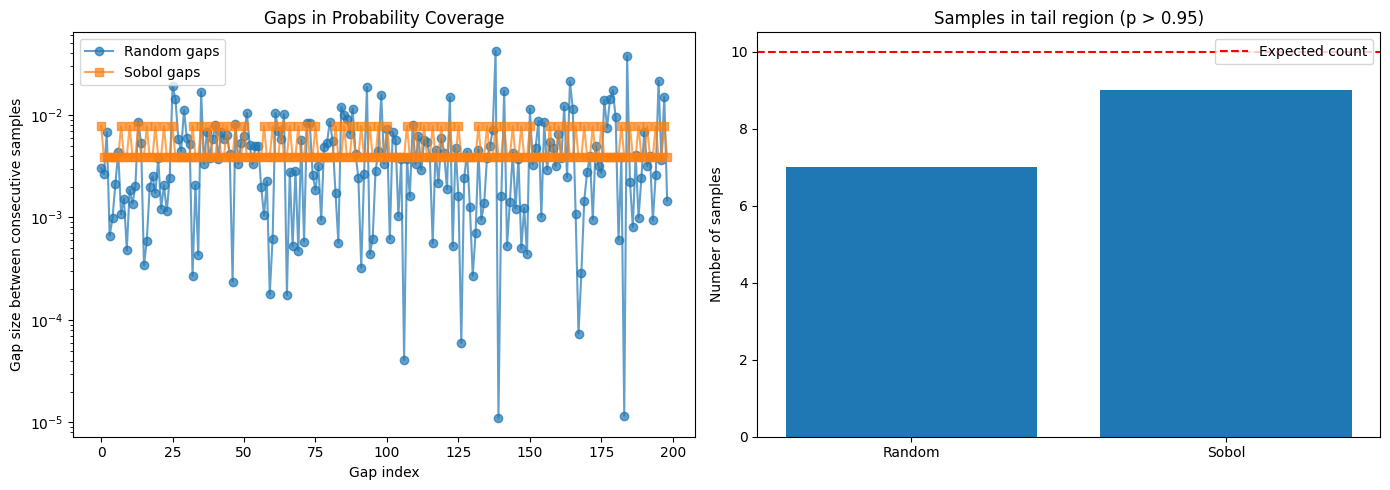

Maximum gap in probability coverage:
  Random: 0.042410
  Sobol: 0.007812


In [3]:
def show_probability_level_coverage(n_points=100):
    """
    Visualize how Sobol ensures coverage of important probability levels
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Generate sequences
    random_u = np.sort(np.random.uniform(0, 1, n_points))
    sobol = qmc.Sobol(d=1, scramble=False)  # No scrambling to see pattern
    sobol_u = np.sort(sobol.random(n_points).flatten())
    
    # Plot 1: Gap analysis
    random_gaps = np.diff(random_u)
    sobol_gaps = np.diff(sobol_u)
    
    ax1.plot(random_gaps, 'o-', alpha=0.7, label='Random gaps')
    ax1.plot(sobol_gaps, 's-', alpha=0.7, label='Sobol gaps')
    ax1.set_ylabel('Gap size between consecutive samples')
    ax1.set_xlabel('Gap index')
    ax1.set_title('Gaps in Probability Coverage')
    ax1.legend()
    ax1.set_yscale('log')
    
    # Plot 2: Coverage in tail region
    tail_region = 0.95
    random_tail = np.sum(random_u > tail_region)
    sobol_tail = np.sum(sobol_u > tail_region)
    
    ax2.bar(['Random', 'Sobol'], [random_tail, sobol_tail])
    ax2.set_ylabel('Number of samples')
    ax2.set_title(f'Samples in tail region (p > {tail_region})')
    ax2.axhline(y=n_points*(1-tail_region), color='red', linestyle='--', 
                label='Expected count')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Maximum gap in probability coverage:")
    print(f"  Random: {np.max(random_gaps):.6f}")
    print(f"  Sobol: {np.max(sobol_gaps):.6f}")

show_probability_level_coverage(n_points=200)

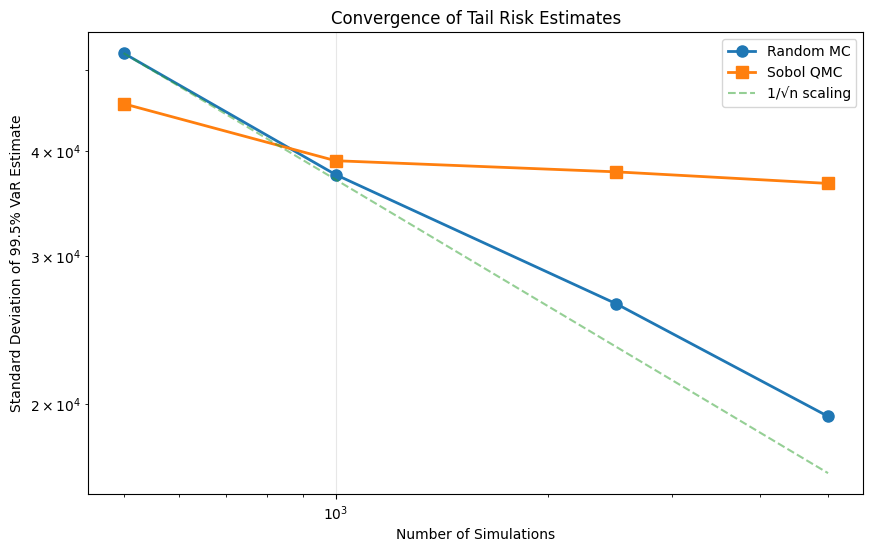

In [ ]:
def poisson_inverse_transform(u, lambda_param):
    """
    Transform uniform random variable to Poisson using inverse CDF.
    This is a simple implementation - for production use, consider
    more efficient algorithms.
    """
    if u == 0:
        return 0

    # Use the CDF: P(X ≤ k) = Σ(λ^i * e^(-λ) / i!) for i from 0 to k
    cumsum = 0.0
    k = 0
    prob_k = np.exp(-lambda_param)  # P(X = 0)
    cumsum = prob_k

    while cumsum < u:
        k += 1
        prob_k *= lambda_param / k  # P(X = k) = P(X = k-1) * λ / k
        cumsum += prob_k

    return k


def stratified_sobol_approach(lambda_freq, mu_sev, sigma_sev, n_sims=1000):
    """
    Use Sobol for the most important source of variance (frequency),
    but standard MC for severities
    """
    # Generate Sobol sequence just for frequencies
    sobol_1d = qmc.Sobol(d=1, scramble=True)
    freq_uniforms = sobol_1d.random(n_sims).flatten()

    losses = []
    for i in range(n_sims):
        # Sobol-driven frequency
        freq = poisson_inverse_transform(freq_uniforms[i], lambda_freq)

        # Standard random severities
        if freq > 0:
            sevs = np.random.lognormal(mu_sev, sigma_sev, freq)
            losses.append(np.sum(sevs))
        else:
            losses.append(0)

    return losses


def insurance_tail_estimation_comparison(n_sims=1000):
    """
    Compare VaR estimation accuracy for insurance losses
    """
    # Parameters for aggregate loss
    # Frequency: Poisson(25), Severity: Lognormal(μ=7, σ=1.5)
    lambda_freq = 25
    mu_sev, sigma_sev = 7, 1.5

    # We'll estimate 99.5% VaR using different sample sizes
    sample_sizes = [500, 1000, 2500, 5000]
    n_replications = 100

    results = {'Random': [], 'Sobol': []}

    for n in sample_sizes:
        random_vars = []
        sobol_vars = []

        for rep in range(n_replications):
            # Random approach
            random_losses = []
            for i in range(n):
                freq = np.random.poisson(lambda_freq)
                if freq > 0:
                    sevs = np.random.lognormal(mu_sev, sigma_sev, freq)
                    random_losses.append(np.sum(sevs))
                else:
                    random_losses.append(0)
            random_vars.append(np.percentile(random_losses, 99.5))

            sobol_losses = stratified_sobol_approach(lambda_freq, mu_sev, sigma_sev, n_sims=n)
            sobol_vars.append(np.percentile(sobol_losses, 99.5))

        results['Random'].append(np.std(random_vars))
        results['Sobol'].append(np.std(sobol_vars))

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.loglog(sample_sizes, results['Random'], 'o-', linewidth=2,
               markersize=8, label='Random MC')
    plt.loglog(sample_sizes, results['Sobol'], 's-', linewidth=2,
               markersize=8, label='Sobol QMC')

    # Add reference lines
    plt.loglog(sample_sizes, results['Random'][0]*np.sqrt(sample_sizes[0]/np.array(sample_sizes)),
               '--', alpha=0.5, label='1/√n scaling')

    plt.xlabel('Number of Simulations')
    plt.ylabel('Standard Deviation of 99.5% VaR Estimate')
    plt.title('Convergence of Tail Risk Estimates')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


# This will take a moment to run
insurance_tail_estimation_comparison()